# AIPI 590 - XAI | Assignment #06





This assignment analyzes the Wine Quality dataset using a Random Forest model. It begins with exploratory data analysis to examine correlations among features, followed by training a model on scaled data. The analysis generates Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) plots for the 'alcohol' feature to illustrate its impact on the model’s predictions. Additionally, Accumulated Local Effects (ALE) plots are created to provide insights into alcohol’s localized effects while accounting for interactions with other features. For the assignment, I used ChatGPT and class material [global_explanations.ipynb](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/global_explanations.ipynb) as guidance.

Shunxin Zhang

Notebook:https://colab.research.google.com/github/zsx711/AIPI-590/blob/main/notebook/AIPI_590_Assignment06.ipynb [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zsx711/AIPI-590/blob/main/notebook/AIPI_590_Assignment06.ipynb)

In [1]:
# Install necessary libraries
!pip install pandas matplotlib seaborn scikit-learn alibi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.5 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 24.2.0
    Uninstalling attrs-24.2.0:
      Successfully uninstalled attrs-24.2.0
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.24.0
    Uninstalling scikit-image-0.24.0:
      Successfully uninstalled scikit-image-0.24.0


In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
from alibi.explainers import ALE

In [7]:
# Check if the repository already exists, and remove it if so
repo_name = "AIPI-590"
if os.path.exists(repo_name):
    !rm -rf {repo_name}  # Remove the existing directory

# Clone GitHub repository (AIPI-590)
repo_name = "AIPI-590"
git_path = 'https://github.com/zsx711/AIPI-590.git'
!git clone "{git_path}"

# Change the working directory to 'notebook' inside your repo
notebook_dir = 'notebook'
path_to_notebook = os.path.join(repo_name, notebook_dir)
%cd "{path_to_notebook}"

Cloning into 'AIPI-590'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 135 (delta 41), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (135/135), 3.27 MiB | 11.88 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/AIPI-590/notebook


       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

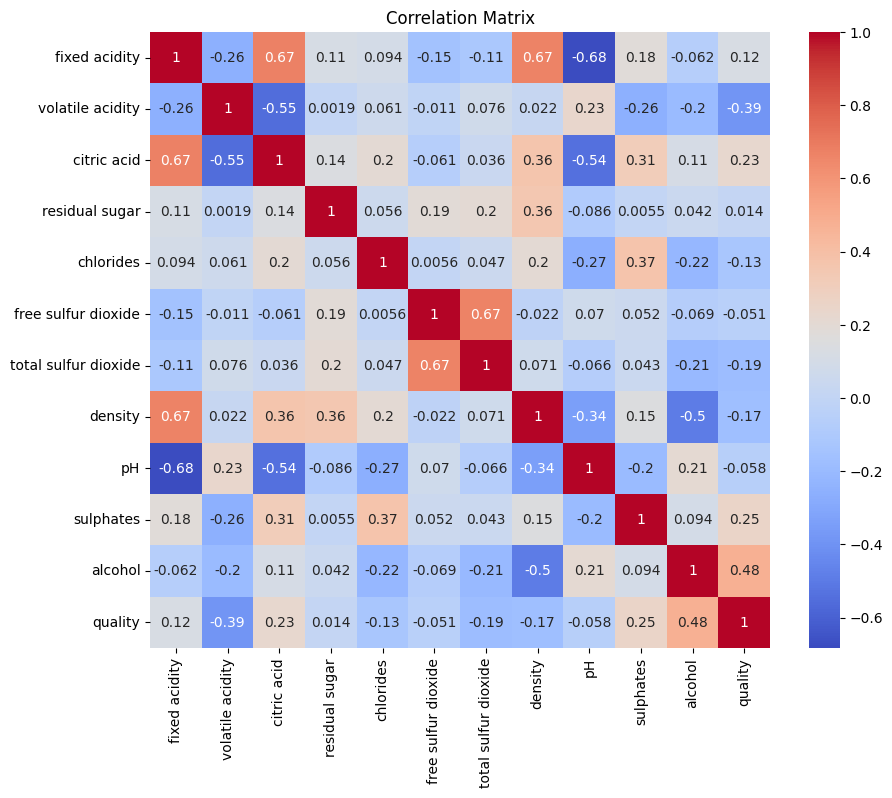

In [4]:
# Load the Wine Quality dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';')

# Perform basic exploratory analysis
print(df.describe())

# Visualize correlations between features
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without featu

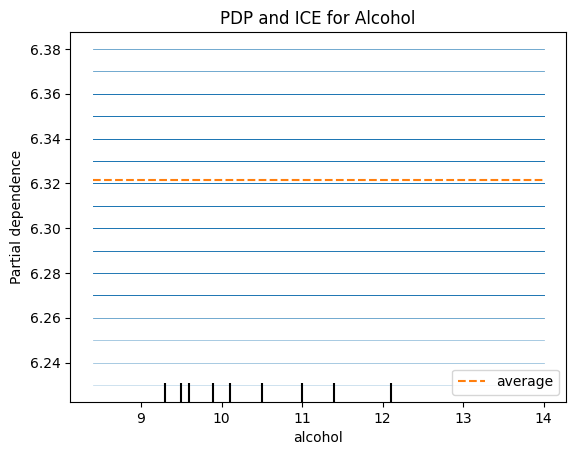

In [5]:
# Split the data
X = df.drop('quality', axis=1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a RandomForest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# PDP and ICE plot for 'alcohol'
features = ['alcohol']  # Feature to plot

# Use unscaled data for plotting, but keep the model predictions on scaled data
PartialDependenceDisplay.from_estimator(
    model,
    X_test,  # Use unscaled data here to match feature names
    features,
    kind='both',  # Show both ICE and PDP
    grid_resolution=50
)
plt.title('PDP and ICE for Alcohol')
plt.show()

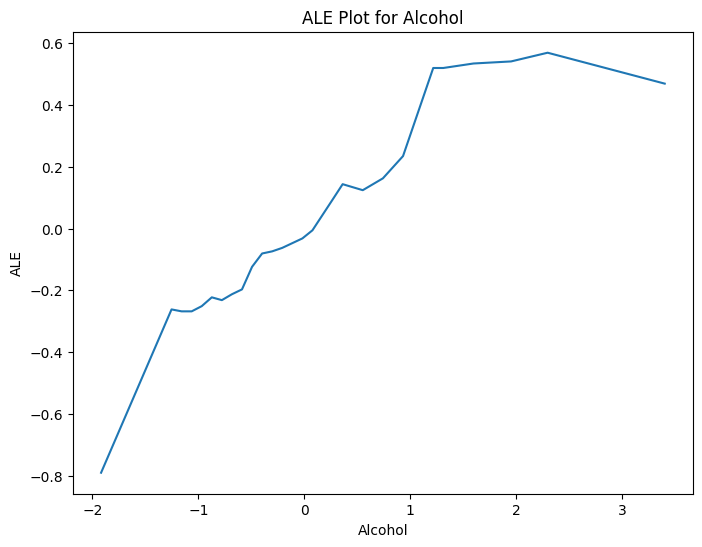

In [6]:
# ALE plot for 'alcohol'
ale = ALE(model.predict, feature_names=X.columns)
explanation = ale.explain(X_test_scaled)  # ALE works with scaled data

# Find the index of the feature 'alcohol' in the feature_names list
feature_idx = X.columns.get_loc('alcohol')
ale_values = explanation.ale_values[feature_idx]
ale_feature_values = explanation.feature_values[feature_idx]

# Plot ALE for 'alcohol'
plt.figure(figsize=(8, 6))
plt.plot(ale_feature_values, ale_values)
plt.xlabel('Alcohol')
plt.ylabel('ALE')
plt.title('ALE Plot for Alcohol')
plt.show()


# Explaination and Findings
The Partial Dependence Plot (PDP) and Individual Conditional Expectation (ICE) plots for the 'alcohol' feature in the Wine Quality dataset reveal a clear positive relationship between alcohol content and wine quality — higher alcohol levels generally correspond to higher quality ratings. The PDP shows the average effect of alcohol across all samples, while the ICE plot highlights individual variations, illustrating that the impact of alcohol content can differ from one wine to another. The Accumulated Local Effects (ALE) plot also indicates a positive relationship, but unlike the PDP, it adjusts for correlations between features, providing a more refined view of alcohol's influence. Interestingly, the ALE plot diverges slightly from the PDP because it accounts for feature interactions, such as with 'sulphates' and 'citric acid,' which are somewhat correlated with alcohol content. This difference suggests that the PDP might overstate the effect of alcohol since it doesn’t consider these interactions, whereas ALE offers a more reliable estimate by factoring them in. In my exploratory analysis, I noticed these correlations, and understanding these relationships provided me with more accurate insights into how alcohol content influences wine quality in the model.